In [1]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

from distfit import distfit
from scipy.stats import norm,dweibull
from keras.models import load_model
import pandas as pd
import numpy as np
from keras.layers import Dense,Conv1D,Convolution1D,Activation,MaxPooling1D,Flatten,Dropout

from keras.callbacks import TensorBoard
from keras import regularizers
import scglue
import scanpy as sc

from anndata import AnnData


class scLTNN(object):
    r"""single cell latent time neuron network
    
    """
    
    def __init__(self,adata):
        self.adata_raw=adata
        self.adata_test=adata.copy()
        
    def creat_radio_model(self,input_dim):
        r"""Created the base ANN model
        
        Arguments
        ---------
        input_dim:
            The input dimension of ANN model

        Returns
        -------
        model:
            The ANN model construct by keras
        
        """

        model=Sequential(name='scLTNN_model')

        model.add(Dense(512,input_dim = input_dim,activation="relu"))
        model.add(Dense(512,activation="relu"))
        model.add(Dense(512,activation="relu"))
        model.add(Dense(1,activation = "linear"))

        model.compile(optimizer='adam',loss="mean_squared_error",metrics=["mean_absolute_error"])
        print(model.summary())
        return model
        
    def load_model(self,model_path):
        r"""load the ANN model constructed by primriary training

        Arguments
        ---------
        model_path:
            the path of the ANN model constructed by primriart training
        
        """
        self.model=load_model(model_path)
        
    def cal_high_variable_genes(self,n_top_genes=10000):
        r"""calualate the high variable genes by seurat_v3 of scanpy

        Arguments
        ---------
        n_top_genes:
            the num of the high variable genes selected
        
        """
        print('......calculate high_variable_genes',n_top_genes)
        sc.pp.highly_variable_genes(self.adata_test, n_top_genes=n_top_genes, flavor="seurat_v3")
        self.adata_test=self.adata_test[:,self.adata_test.var['highly_variable']==True]
        
    def cal_lsi(self,n_components=100):
        r"""calculate the latent semantic index of scRNA-seq

        Arguments
        ---------
        n_components:
            the num latent dimension of LSI 
        
        """
        print('......calculate lsi')
        self.n_components=n_components
        scglue.data.lsi(self.adata_test, n_components=n_components, n_iter=15)
        
    def cal_paga(self,resolution=1.0):
        r"""calculate the paga graph by community detection of leiden

        Arguments
        ---------
        resolution:
            A parameter value controlling the coarseness of the clustering.
            Higher values lead to more clusters.
            Set to `None` if overriding `partition_type`
            to one that doesn’t accept a `resolution_parameter`.
        
        """
        print('......calculate paga')
        sc.pp.neighbors(self.adata_test, n_neighbors=10, n_pcs=40)
        sc.tl.leiden(self.adata_test, resolution=1.0)
        sc.tl.paga(self.adata_test, groups='leiden')
        
    def cal_model_time(self):
        r"""predict the latent time by primriary ANN model

        Arguments
        ---------
        
        """
        print('......predict model_time')
        X_val=self.adata_test.obsm['X_lsi']
        PredValSet=(self.model.predict(X_val))
        self.adata_test.obs['p_time']=PredValSet.T[0]
        self.adata_test.obs['p_time_r']=1-PredValSet.T[0]
        
    def cal_rps_value(self,species='human',rev=True):
        r"""calculate the mean of rps protein in start and end node 
        
        Arguments
        ---------
        species:
            the species of scRNA-seq
            human:human
            mouse:mouse
        
        """
        print('......calculate RPS value')
        if species=='human':
            rps_name='RPS'
        elif species=='mouse':
            rps_name='Rps'
        RPS_s=self.adata_test[self.adata_test.obs['p_time']<0.2,self.adata_test.var.index.str.contains(rps_name)].X.mean()
        RPS_l=self.adata_test[self.adata_test.obs['p_time']>0.8,self.adata_test.var.index.str.contains(rps_name)].X.mean()
        if (RPS_l>1):
            if ((RPS_s>RPS_l)):
                self.adata_test.obs['p_latent_time']=self.adata_test.obs['p_time']
            else:
                self.adata_test.obs['p_latent_time']=self.adata_test.obs['p_time_r']
        else:
            self.adata_test.obs['p_latent_time']=self.adata_test.obs['p_time']
            
    def cal_dpt_pseudotime(self,leiden_range=0.01,rev=False):
        r"""calculate the diffusion pseudotime of anndata by start node selected automatically

        Arguments
        ---------
        leiden_range:
            the range of start and end node

        rev:
            test function to use the end node

        """

        print('......calculate dpt_pseudotime')
        leiden_pd=pd.DataFrame(columns=['Time_value'])
        for i in set(self.adata_test.obs['leiden']):
            leiden_pd.loc[i]={'Time_value':self.adata_test.obs.loc[self.adata_test.obs['leiden']==i,'p_latent_time'].mean()}
        leiden_pd=leiden_pd.sort_values('Time_value')
        self.leiden_pd=leiden_pd
        leiden_start=leiden_pd.index[0]
        leiden_end=leiden_pd.index[-1]

        self.leiden_start=leiden_pd.loc[leiden_pd['Time_value']<leiden_pd.loc[leiden_pd.index[0]].values[0]+leiden_range].index.tolist()
        self.leiden_end=leiden_pd.loc[leiden_pd['Time_value']>leiden_pd.loc[leiden_pd.index[-1]].values[0]-leiden_range].index.tolist()
        
        print('......leiden_start',self.leiden_start,'leiden_end',self.leiden_end)
        
        #prev
        self.adata_test.uns['iroot'] = np.flatnonzero(self.adata_test.obs['leiden'].isin(self.leiden_start))[0]
        sc.tl.diffmap(self.adata_test)
        sc.tl.dpt(self.adata_test)
        self.adata_test.obs['dpt_pseudotime_p']=self.adata_test.obs['dpt_pseudotime'].values

        #middle
        leiden_dpt_pd=pd.DataFrame(columns=['Time_value'])
        for i in set(self.adata_test.obs['leiden']):
            leiden_dpt_pd.loc[i]={'Time_value':self.adata_test.obs.loc[self.adata_test.obs['leiden']==i,'dpt_pseudotime'].mean()}
        leiden_dpt_pd=leiden_dpt_pd.sort_values('Time_value') 
        self.leiden_dpt_pd=leiden_dpt_pd
        leiden_sum=len(leiden_dpt_pd)
        leiden_middle=leiden_sum//2
        
        leiden_middle_index=leiden_dpt_pd.iloc[leiden_middle].name
        leiden_middle_value=leiden_dpt_pd.iloc[leiden_middle].values[0]

        self.leiden_middle=leiden_dpt_pd.loc[(leiden_dpt_pd['Time_value']<leiden_middle_value+0.05)&
                        (leiden_dpt_pd['Time_value']>leiden_middle_value-0.05)].index.tolist()

        
        #rev
        if rev==True:
            self.adata_test.uns['iroot'] = np.flatnonzero(self.adata_test.obs['leiden'].isin(self.leiden_end))[0]
            sc.tl.diffmap(self.adata_test)
            sc.tl.dpt(self.adata_test)
            self.adata_test.obs['dpt_pseudotime_r']=np.max(self.adata_test.obs['dpt_pseudotime'].values)-self.adata_test.obs['dpt_pseudotime'].values

            self.adata_test.obs['dpt_pseudotime']=(self.adata_test.obs['dpt_pseudotime_p'].values+self.adata_test.obs['dpt_pseudotime_r'].values)/2
        else:
            self.adata_test.obs['dpt_pseudotime']=self.adata_test.obs['dpt_pseudotime_p']
        
        
    def ANN(self,batch_size=30,epochs=10,verbose=0,mode='p_time'):
        r"""regression of latent time by start and end node using ANN model
        
        Arguments
        ---------
        batch_size:
            the batch_size of ANN model

        epochs:
            the epochs of ANN model

        verbose:
            the visualization of ANN model summary

        mode:
            the calculation mode of ANN model
            if we want to use the diffusion time to regression the ANN model
            we can set the model 'dpt_time'
        
        """
        print('......ANN')
        plot_pd=pd.DataFrame()
        plot_pd['cell_id']=self.adata_test.obs.index
        plot_pd['leiden']=self.adata_test.obs.loc[plot_pd['cell_id'],'leiden'].values
        plot_pd['dpt_time']=self.adata_test.obs['dpt_pseudotime'].values
        plot_pd['p_latent_time']=self.adata_test.obs['p_latent_time'].values
        a1=plot_pd.loc[plot_pd['leiden'].isin(self.leiden_start)].copy()
        #a1['p_time']=np.random.normal(0.07, 0.03, len(a1))
        a2=plot_pd.loc[plot_pd['leiden'].isin(self.leiden_end)].copy()
        #a2['p_time']=np.random.normal(0.93, 0.03, len(a2))
        a3=plot_pd.loc[plot_pd['leiden'].isin(self.leiden_middle)].copy()

        a1['p_time']=np.random.normal(0.07, 0.03, len(a1))
        a2['p_time']=np.random.normal(0.93, 0.03, len(a2))
        a3['p_time']=np.random.normal(0.5, 0.05, len(a3))

        train_pd=pd.concat([a1,a3,a2])
        train_pd.index=train_pd['cell_id']



        ran=np.random.choice(train_pd.index.tolist(),8*(len(train_pd)//10))
        ran_r=list(set(train_pd.index.tolist())-set(ran))

        if mode=='p_time':
            X_train=self.adata_test[ran].obsm['X_lsi']
            #Y_train=adata_test.obs.loc[ran,'p_latent_time']
            Y_train=train_pd.loc[ran,'p_time']
            X_test=self.adata_test[ran_r].obsm['X_lsi']
            #Y_test=adata_test.obs.loc[ran_r,'p_latent_time']
            Y_test=train_pd.loc[ran_r,'p_time']
        elif mode=='dpt_time':
            X_train=self.adata_test[ran].obsm['X_lsi']
            #Y_train=adata_test.obs.loc[ran,'p_latent_time']
            Y_train=train_pd.loc[ran,'dpt_time']
            X_test=self.adata_test[ran_r].obsm['X_lsi']
            #Y_test=adata_test.obs.loc[ran_r,'p_latent_time']
            Y_test=train_pd.loc[ran_r,'dpt_time']
        
        self.model_ANN=self.creat_radio_model(self.n_components)
        history1=self.model_ANN.fit(X_train, Y_train.values,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=verbose,
                  validation_data=(X_test, Y_test.values),)
        score1 = self.model_ANN.evaluate(X_test, Y_test.values, verbose=verbose)
        print('......ANN:loss',score1[0],'MAE',score1[1])
        print('......predicted ANN Time')
        X_val=self.adata_test.obsm['X_lsi']
        PredValSet=self.model_ANN.predict(X_val)
        self.adata_test.obs['p_ANN_time']=PredValSet.T[0]
    
    def cal_distrubute(self) -> None:
        r"""calculate the distribution of ANN time and diffusion pseudotime
        
        Arguments
        ---------
        
        """


        print('......Dweibull analysis')
        dist1 = distfit(todf=True)
        dist1.fit_transform(self.adata_test.obs[['dpt_pseudotime']].values)
        loc_dweibull=dist1.summary.loc[dist1.summary['distr']=='dweibull','loc'].values[0]
        scale_dweibull=dist1.summary.loc[dist1.summary['distr']=='dweibull','scale'].values[0]
        c_dweibull=dist1.summary.loc[dist1.summary['distr']=='dweibull','arg'].values[0][0]
        self.dweibull_arg={'c':c_dweibull,'loc':loc_dweibull,'scale':scale_dweibull}
        
        print('......Norm analysis')
        dist2 = distfit(todf=True)
        dist2.fit_transform(self.adata_test.obs[['p_ANN_time']].values)
        loc_norm=dist2.summary.loc[dist2.summary['distr']=='norm','loc'].values[0]
        scale_norm=dist2.summary.loc[dist2.summary['distr']=='norm','scale'].values[0]
        self.norm_arg={'loc':loc_norm,'scale':scale_norm}
        self.dist1=dist1
        self.dist2=dist2
        
    
    def distribute_fun(self,mode,x1,x2):
        r"""calculate the distribution of model

        Arguments
        ---------
        mode
            - Norm: the normal module of scLTNN distribution
            - Best_all: the best distribution to use in scLTNN time calcultion
            - Best_dweibull: the best distribution of ANN model 
            time to use in  scLTNN time calcultion
        x1
            the dpt_pseudotime of adata
        x2
            the p_ANN_time of adata
        
        Returns
        -------
        x
            the composition of x1 and x2 by special distribution
        """
        if mode=='Norm':
            a1=(norm.pdf(x1,loc=self.norm_arg['loc'],scale=self.norm_arg['scale']))
            a2=(dweibull.pdf(x2,self.dweibull_arg['c'],loc=self.dweibull_arg['loc'],scale=self.dweibull_arg['scale']))
        elif mode=='Best_all':
            a1=(self.dist2.model['distr'].pdf(x1,*self.dist2.model['params']))
            a2=(self.dist1.model['distr'].pdf(x2,*self.dist1.model['params']))
        elif mode=='Best_dweibull':
            a1=(self.dist2.model['distr'].pdf(x1,*self.dist2.model['params']))
            a2=(dweibull.pdf(x2,self.dweibull_arg['c'],loc=self.dweibull_arg['loc'],scale=self.dweibull_arg['scale']))
        
        return x1*(a1/(a1+a2))+x2*(a2/(a1+a2))

    def cal_scLTNN_time(self,mode='Norm'):
        r"""calcualte the scLTNN time of anndata
        
        Arguments
        ---------
        mode:
            'Norm': the normal module of scLTNN distribution
            'Best_all' the best distribution to use in scLTNN time calcultion
            'Best_dweibull': the best distribution of ANN model 
            time to use in  scLTNN time calcultion
        
        """
        print('......calculate scLTNN time')
        new_x=[]
        for i in self.adata_test.obs.index:
            x1=self.adata_test.obs.loc[i,'dpt_pseudotime']
            x2=self.adata_test.obs.loc[i,'p_ANN_time']
            x=self.distribute_fun(mode,x1,x2)
            new_x.append(x)
        self.adata_test.obs['LTNN_time']=new_x
        self.adata_test.obs['LTNN_time_r']=1-np.array(new_x)


In [11]:
import keras
print(keras.__version__)
import scanpy as sc
print(sc.__version__)
import scvelo as scv
print(scv.__version__)
import matplotlib
print(matplotlib.__version__)

2.8.0
1.9.1
0.2.4
3.5.2


In [1]:
import anndata
adata6=anndata.read_h5ad('../data/scvelo-pancreas.h5ad')
adata2=anndata.read_h5ad('../data/tsp1_bladder_mesenchymeToMyofibroblast_forPaper.h5ad')
adata1=anndata.read_h5ad('../data/tsp2_bladder_mesenchymeToMyofibroblast_forPaper.h5ad')

In [2]:
import scvelo as scv
import scltnn
adata6=scv.datasets.pancreas()
scpancera=scltnn.models.scLTNN(adata6)
scpancera.load_model('../model/my_model1.h5')
scpancera.cal_high_variable_genes()
scpancera.cal_lsi(n_components=100)
scpancera.cal_paga(resolution=1.0)
scpancera.cal_model_time()
scpancera.cal_rps_value(species='mouse')
scpancera.cal_dpt_pseudotime(leiden_range=0.01)
scpancera.ANN(batch_size=30,epochs=10,verbose=0)
scpancera.cal_distrubute()
scpancera.cal_scLTNN_time()

Metal device set to: Apple M1 Pro
......calculate high_variable_genes 10000


2022-07-28 02:21:30.394239: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-28 02:21:30.394353: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


......calculate lsi
......calculate paga
......predict model_time


2022-07-28 02:21:36.294117: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-28 02:21:36.330187: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


......calculate RPS value
......calculate dpt_pseudotime
......leiden_start: ['7']
......leiden_middle ['15', '12']
......leiden_end ['5', '4']
......ANN
Model: "scLTNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               51712     
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                                 
Total params: 577,537
Trainable params: 577,537
Non-trainable params: 0
_________________________________________________________________
None


2022-07-28 02:21:37.121845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-28 02:21:37.526019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


......ANN:loss 0.016562720760703087 MAE 0.10141551494598389
......predicted ANN Time


2022-07-28 02:21:39.530008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


......Dweibull analysis
[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 92.8354] [loc=0.534 scale=0.355]
[distfit] >[expon     ] [0.00 sec] [RSS: 85.8612] [loc=0.000 scale=0.534]
[distfit] >[pareto    ] [0.06 sec] [RSS: 84.3839] [loc=-91416821.415 scale=91416821.415]
[distfit] >[dweibull  ] [0.01 sec] [RSS: 64.4709] [loc=0.447 scale=0.379]
[distfit] >[t         ] [0.04 sec] [RSS: 92.835] [loc=0.534 scale=0.355]
[distfit] >[genextreme] [0.04 sec] [RSS: 77.2495] [loc=0.497 scale=0.397]
[distfit] >[gamma     ] [0.03 sec] [RSS: 93.3241] [loc=-5.047 scale=0.023]
[distfit] >[lognorm   ] [0.07 sec] [RSS: 92.9369] [loc=-57.794 scale=58.324]
[distfit] >[beta      ] [0.05 sec] [RSS: 76.726] [loc=-0.088 scale=1.088]
[distfit] >[uniform   ] [0.00 sec] [RSS: 76.2608] [loc=0.000 scale=1.000]
[distfit] >[loggamma  ] [0.01 sec] [RSS: 65.7125] [loc=0.948 scale=0.020]
[distfit] >Compute confidence interval [parametric]
......Norm analysis
[distfit] >fit..
[distfit] >tran

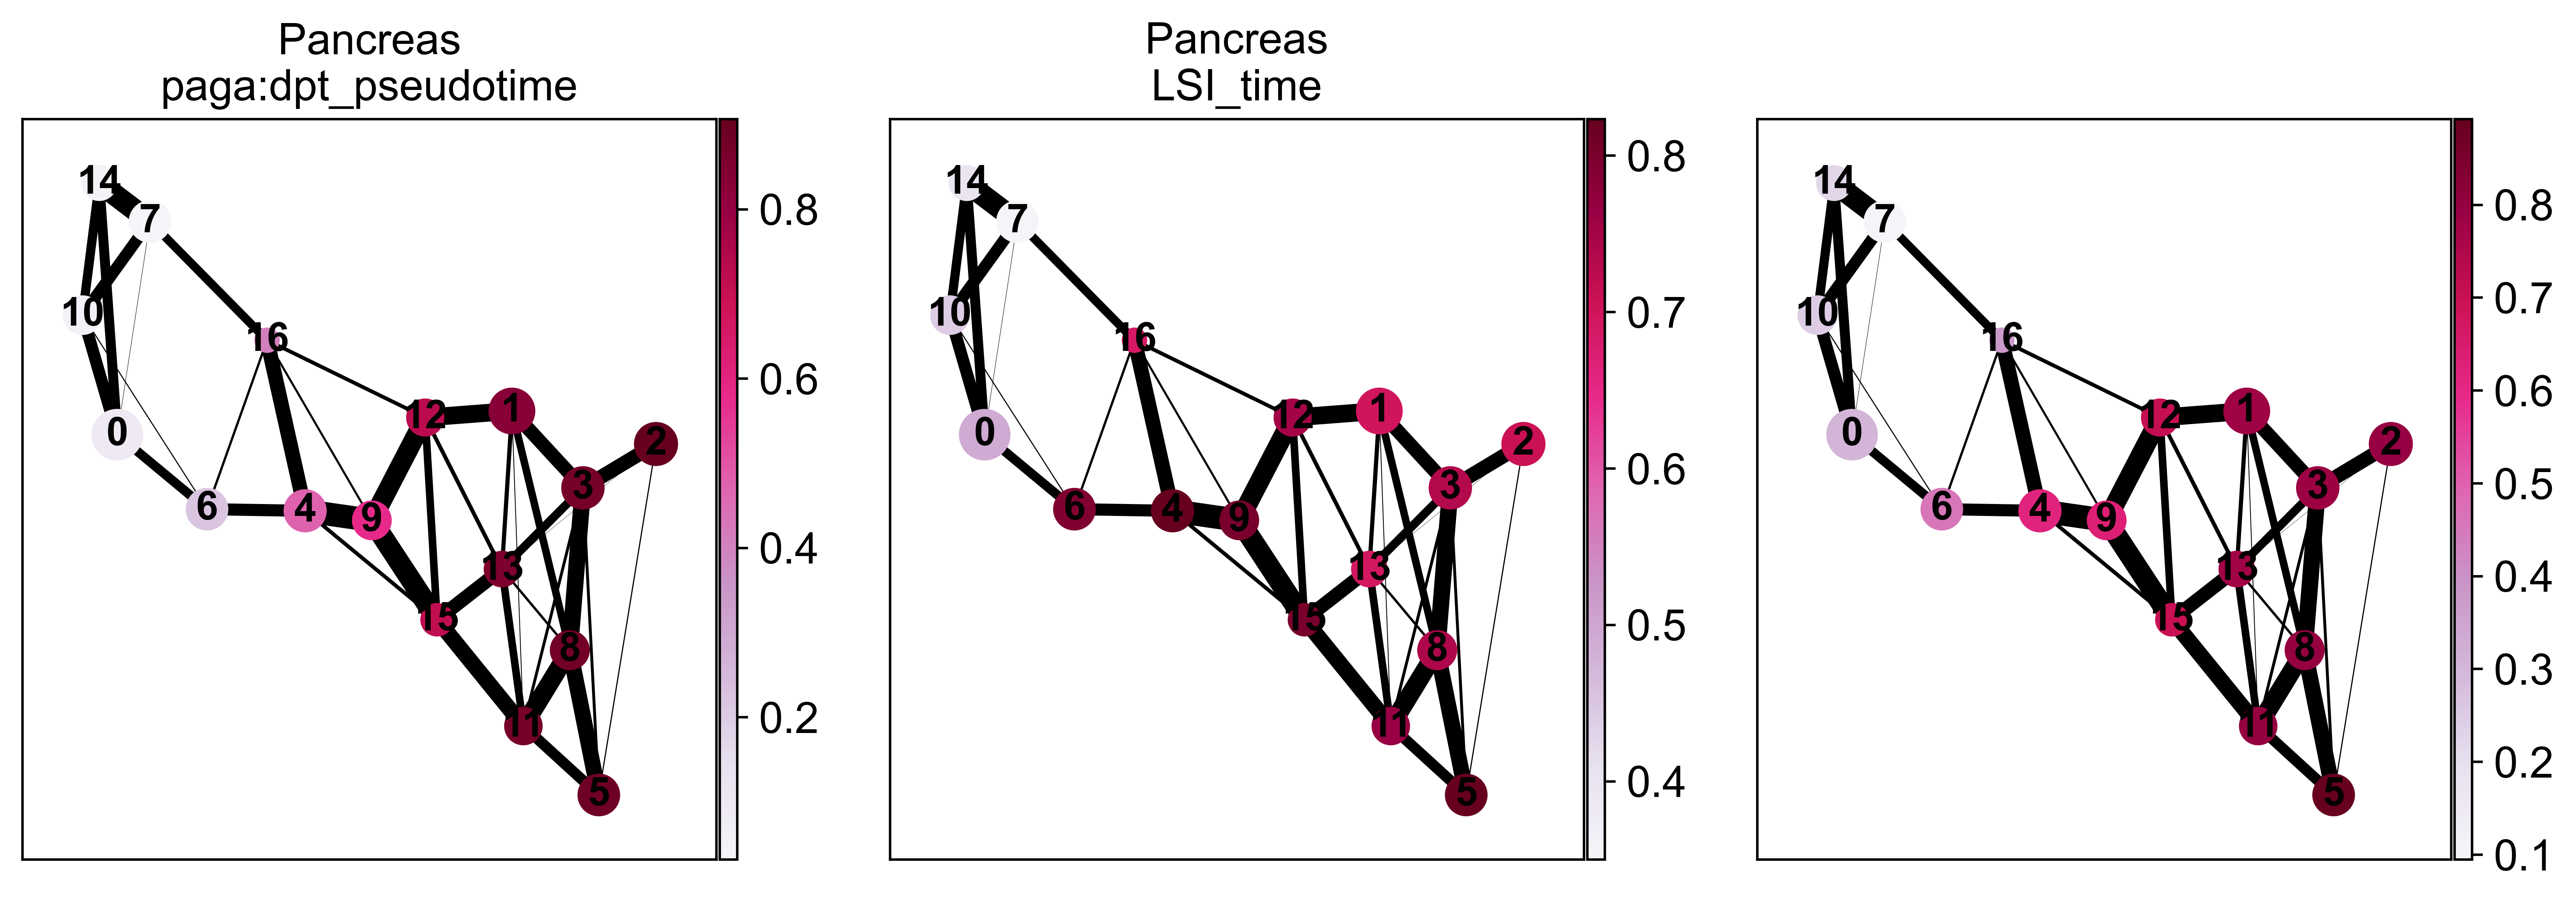

In [3]:
import scanpy as sc
sc.settings.set_figure_params(dpi=300, facecolor='white')
sc.pl.paga(scpancera.adata_test, color=['dpt_pseudotime','p_latent_time','LTNN_time'],cmap='PuRd',
          title=['Pancreas\npaga:dpt_pseudotime','Pancreas\nLSI_time',''],)
          #save='_fig3_pancreas.png')